In [1]:
from sklearn.datasets import make_moons
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
import numpy as np
import tensorflow as tf
from datetime import datetime
import os

F:\ML\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
m = 1000

In [3]:
X_moons, y_moons = make_moons(m, noise=0.1, random_state=42)

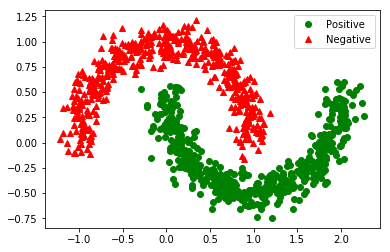

In [4]:
plt.plot(X_moons[y_moons == 1, 0], X_moons[y_moons == 1, 1], 'go', label="Positive")
plt.plot(X_moons[y_moons == 0, 0], X_moons[y_moons == 0, 1], 'r^', label="Negative")
plt.legend()
plt.show()

In [5]:
X_moons_with_bias = np.c_[np.ones((m,1)), X_moons]

In [6]:
y_moons_column_vector = y_moons.reshape(-1,1)

In [7]:
test_ratio = 0.2
test_size = int(m * test_ratio)

In [8]:
X_train = X_moons_with_bias[:-test_size]
X_test = X_moons_with_bias[-test_size:]
y_train = y_moons_column_vector[:-test_size]
y_test = y_moons_column_vector[-test_size:]

In [9]:
def random_batch(X_train, y_train, batch_size):
    rnd_index = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_index]
    y_batch = y_train[rnd_index]
    return X_batch, y_batch

In [10]:
tf.reset_default_graph()

In [11]:
n_inputs = 2

In [12]:
X = tf.placeholder(tf.float32, shape = (None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape = (None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n_inputs + 1, 1], -1.0, 1.0, seed=42), name="theta")
logits = tf.matmul(X, theta, name = "logits")
y_proba = tf.sigmoid(logits) # 1/(1 + tf.exp(-logits))

In [13]:
#epsilon = 1e-7
#loss = -tf.reduce_mean(y * tf.log(y_proba + epsilon) + (1-y) * tf.log(1 - y_proba + epsilon)))

loss = tf.losses.log_loss(y, y_proba) # uses epsilon = 1e-7 by default

In [14]:
learning_rate = 0.03
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(loss)

In [15]:
init = tf.global_variables_initializer()

In [16]:
n_epochs = 1000
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict = { X: X_batch, y: y_batch})
        loss_val = loss.eval({X: X_test, y: y_test})
        if epoch % 100 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
    y_proba_val = y_proba.eval(feed_dict={X: X_test, y: y_test})

Epoch: 0 	Loss: 0.8241411
Epoch: 100 	Loss: 0.29466102
Epoch: 200 	Loss: 0.27823094
Epoch: 300 	Loss: 0.27499285
Epoch: 400 	Loss: 0.274329
Epoch: 500 	Loss: 0.27383807
Epoch: 600 	Loss: 0.27350292
Epoch: 700 	Loss: 0.27446875
Epoch: 800 	Loss: 0.27415168
Epoch: 900 	Loss: 0.27452543


In [17]:
y_proba_val[:5]

array([[0.5731288 ],
       [0.6814609 ],
       [0.54304165],
       [0.99514365],
       [0.4909844 ]], dtype=float32)

In [18]:
y_pred = (y_proba_val >= 0.5)
y_pred[:5]

array([[ True],
       [ True],
       [ True],
       [ True],
       [False]])

In [19]:
print("Precision score:", precision_score(y_test, y_pred), "\tRecall score:", recall_score(y_test, y_pred))

Precision score: 0.8571428571428571 	Recall score: 0.9090909090909091


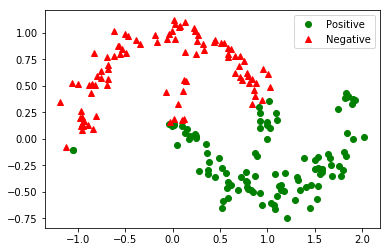

In [20]:
y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()

In [29]:
X_train_enhanced = np.c_[X_train,
                         np.square(X_train[:, 1]),
                         np.square(X_train[:, 2]),
                         X_train[:, 1] ** 3,
                         X_train[:, 2] ** 3]
X_test_enhanced = np.c_[X_test,
                        np.square(X_test[:, 1]),
                        np.square(X_test[:, 2]),
                        X_test[:, 1] ** 3,
                        X_test[:, 2] ** 3]

In [56]:
tf.reset_default_graph()

In [57]:
def logistic_regression(X, y, initializer=None, seed=42, learning_rate=0.022):
    n_inputs_including_bias = int(X.get_shape()[1])
    with tf.name_scope("logistic_regression"):
        with tf.name_scope("model"):
            if initializer is None:
                initializer = tf.random_uniform([n_inputs_including_bias, 1], -1.0, 1.0, seed=seed)
            theta = tf.Variable(initializer, name="theta")
            logits = tf.matmul(X, theta, name = "logits")
            y_proba = tf.sigmoid(logits) # 1/(1 + tf.exp(-logits))  
        with tf.name_scope("train"):
            loss = tf.losses.log_loss(y, y_proba, scope="loss")
            optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
            training_op = optimizer.minimize(loss)
            loss_summary = tf.summary.scalar('log_loss', loss)
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
        with tf.name_scope("save"):
            saver = tf.train.Saver()
    return y_proba, loss, training_op, loss_summary, init, saver

In [58]:
def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

In [59]:
n_inputs = 2 + 4
logdir = log_dir("logreg")

X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [60]:
n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = "/tmp/my_logreg_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_logreg_model"

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)

    for epoch in range(start_epoch, n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
        file_writer.add_summary(summary_str, epoch)
        if epoch % 500 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))

    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
    os.remove(checkpoint_epoch_path)

Epoch: 0 	Loss: 0.7670669
Epoch: 500 	Loss: 0.12022571
Epoch: 1000 	Loss: 0.08251228
Epoch: 1500 	Loss: 0.06569796
Epoch: 2000 	Loss: 0.05617089
Epoch: 2500 	Loss: 0.04991455
Epoch: 3000 	Loss: 0.04542131
Epoch: 3500 	Loss: 0.042122636
Epoch: 4000 	Loss: 0.03946016
Epoch: 4500 	Loss: 0.03733544
Epoch: 5000 	Loss: 0.035655044
Epoch: 5500 	Loss: 0.034154624
Epoch: 6000 	Loss: 0.032879084
Epoch: 6500 	Loss: 0.0318737
Epoch: 7000 	Loss: 0.030874642
Epoch: 7500 	Loss: 0.029981012
Epoch: 8000 	Loss: 0.029313248
Epoch: 8500 	Loss: 0.028573668
Epoch: 9000 	Loss: 0.027986594
Epoch: 9500 	Loss: 0.027419787
Epoch: 10000 	Loss: 0.026870504


In [61]:
y_pred = (y_proba_val >= 0.5)

In [62]:
print("Precision score:", precision_score(y_test, y_pred), "\tRecall score:", recall_score(y_test, y_pred))

Precision score: 0.9797979797979798 	Recall score: 0.9797979797979798


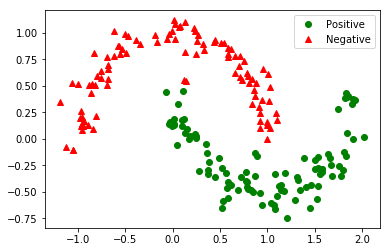

In [63]:
y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()

In [64]:
from scipy.stats import reciprocal

n_search_iterations = 10

for search_iteration in range(n_search_iterations):
    batch_size = np.random.randint(1, 100)
    learning_rate = reciprocal(0.0001, 0.3).rvs(random_state=search_iteration)

    n_inputs = 2 + 4
    logdir = log_dir("logreg")
    
    print("Iteration", search_iteration)
    print("  logdir:", logdir)
    print("  batch size:", batch_size)
    print("  learning_rate:", learning_rate)
    print("  training: ", end="")

    tf.reset_default_graph()

    X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
    y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

    y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(
        X, y, learning_rate=learning_rate)

    file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

    n_epochs = 10001
    n_batches = int(np.ceil(m / batch_size))

    final_model_path = "./my_logreg_model_%d" % search_iteration

    with tf.Session() as sess:
        sess.run(init)

        for epoch in range(n_epochs):
            for batch_index in range(n_batches):
                X_batch, y_batch = random_batch(X_train_enhanced, y_train, batch_size)
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
            file_writer.add_summary(summary_str, epoch)
            if epoch % 500 == 0:
                print(".", end="")

        saver.save(sess, final_model_path)

        print()
        y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
        y_pred = (y_proba_val >= 0.5)
        
        print("  precision:", precision_score(y_test, y_pred))
        print("  recall:", recall_score(y_test, y_pred))

Iteration 0
  logdir: tf_logs/logreg-run-20180901141022/
  batch size: 35
  learning_rate: 0.00809638402661958
  training: .....................
  precision: 0.9797979797979798
  recall: 0.9797979797979798
Iteration 1
  logdir: tf_logs/logreg-run-20180901141928/
  batch size: 45
  learning_rate: 0.00281861706012944
  training: .....................
  precision: 0.9797979797979798
  recall: 0.9797979797979798
Iteration 2
  logdir: tf_logs/logreg-run-20180901142649/
  batch size: 84
  learning_rate: 0.0032810068809124484
  training: .....................
  precision: 0.97
  recall: 0.9797979797979798
Iteration 3
  logdir: tf_logs/logreg-run-20180901143048/
  batch size: 90
  learning_rate: 0.008226045248887452
  training: .....................
  precision: 0.9797979797979798
  recall: 0.9797979797979798
Iteration 4
  logdir: tf_logs/logreg-run-20180901143448/
  batch size: 73
  learning_rate: 0.23039869092007673
  training: .....................
  precision: 0.9801980198019802
  recall: 